# Lesson 14 

Backpropagation continued...  Jeremy points out a nice explaination by one of the students: [Simple Neural Net Backward Pass](https://nasheqlbrm.github.io/blog/posts/2021-11-13-backward-pass.html).  This is similar to what I suggested in the previous notebook: work out the derivatives long hand.  This is a good way to understand the process.

This clarified for me that when he writes `inp.g` , its the gradient of the loss *with respect to* the input.  I.e. $\frac{\partial L}{\partial x}$ where x is the input.  And same for all other similar variables.

As a reminder, the course notebooks are here: [Course Repo](https://github.com/fastai/course22p2)

## Recap

Let's get back to where we were before..  This section uses notebook [04_minibatch_training.ipynb](https://github.com/fastai/course22p2/blob/master/nbs/04_minibatch_training.ipynb)

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# if gpu available, use it
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#x_train, y_train, x_valid, y_valid = x_train.to(device), y_train.to(device), x_valid.to(device), y_valid.to(device)

In [2]:

n,m = x_train.shape
c = y_train.max()+1
nh = 50


class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [3]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [4]:
loss_func = F.cross_entropy

bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [5]:
# helper functions
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

Simple training loop:

In [6]:
lr = 0.5
epochs = 3

for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.12, 0.98
0.12, 0.94
0.08, 0.96


As a reminder, everything there we have implemented ourselves, and as per our rule, we can now use the torch functions like we are above. 

## Refactoring


### Parameters

* Using parameters: pytorch modules have a way to track the parameters, so that you can use `model.parameters()` to get them all.  

In [7]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    #def forward(self, x): return self.l2(self.relu(self.l1(x)))

Note the user of forward rather than `__call__`. This is the way pytorch modules are meant to be used, as the base class `__call__` does some additional work that we were bypassing.  This was also the way our own module implementation was meant to be used.  We should have been using `forward` instead of `__call__`.  

In [8]:
model = MLP(m, nh, 10)
list(model.parameters())
list(model.named_children())

[('l1', Linear(in_features=784, out_features=50, bias=True)),
 ('l2', Linear(in_features=50, out_features=10, bias=True)),
 ('relu', ReLU())]

Now we can just model.parameters() to get all the parameters:

In [9]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

Lets understand how this works. It works by using `__setattr__` to add the parameters to the module.  This is a bit of python magic.  

In [10]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()  # yield from is a shortcut for a loop that yields each element of an iterable

In [11]:
mdl = MyModule(m, nh, 10)
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In our model above we used a list of layers, which Module will not know about.  One way to do this is to call self.add_module manually for each layer, but instead we can use `nn.ModuleList`:

In [12]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)] 

In [13]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x
    
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

nn.Sequential is a convenience class for this kind of model:

In [14]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
fit()

0.12, 0.98
0.13, 0.96
0.11, 0.96


### Optimizers

We can also refactor the common optimization tasks into a class:

In [15]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [16]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
opt = Optimizer(model.parameters())

def fit(model, epochs):
    for epoch in range(epochs):
        for i in range(0, n,  bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()  # much easier
            opt.zero_grad()
        report(loss, preds, yb)

fit(model, 3)

0.16, 0.96
0.10, 0.94
0.07, 0.98


Pytorch of course has this built in, using optim.SGD. 

In [17]:
from torch import optim

# convenient function to get model and optimizer
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

model,opt = get_model()
loss_func(model(xb), yb)


tensor(2.29, grad_fn=<NllLossBackward0>)

### Dataset and DataLoader

In [18]:
# this simple class just pairs x and y, and implements len and getitem

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

train_ds[0:5]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

The dataloader takes care of the batching part.   We will define this as an iterator that yields the next batch of data. 

In [19]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [20]:
train_dl = DataLoader(train_ds, bs)
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [21]:

def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

fit()

0.10, 0.96
0.09, 0.98
0.08, 0.96


#### Now lets shuffle the data to improve the training


In [22]:

import random

class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)
    

from itertools import islice  # slice an iterator

ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[10885, 33590, 41224, 19424, 40818]

In [23]:
import fastcore.all as fc

class BatchSampler():
    def __init__(self, sampler, bs, drop_last = False): fc.store_attr() # fastcore function that stores all arguments as attributes
    def __iter__(self): yield from fc.chunked(self.sampler, self.bs, drop_last=self.drop_last)

`fc.chunked` is a utility in fastcore that splits data into chunks.  It is defined (with some error checking removed) as:

```python
def chunked(it, chunk_sz=None, drop_last=False):
    if not isinstance(it, Iterator): it = iter(it)
    while True:
        res = list(itertools.islice(it, chunk_sz))
        if res and (len(res)==chunk_sz or not drop_last): yield res
        if len(res)<chunk_sz: return
```

In [24]:
batches = BatchSampler(ss, 4)
list(islice(batches, 5))

[[44426, 31656, 40509, 4524],
 [10297, 27656, 31240, 29675],
 [10003, 23618, 46710, 11025],
 [17030, 18800, 18252, 32124],
 [44539, 44079, 6583, 25752]]

Ok lets fix our data loader to use a batch sampler.  The collat is necessary to convert the list of tuples into a tuple of tensors we can pass to the model.

In [25]:
tb = [44,1002,34,33]
bd = (train_ds[i] for i in tb)
xs,ys = zip(*bd)  # zip(*iterable) is a common idiom to transpose a list of lists

In [26]:
example = [(1,2), (3,4), (5,6)]
list(zip(*example))

[(1, 3, 5), (2, 4, 6)]

In [27]:
# usual think of usign zip in this case
example2 = [[1,2,3,4,5],["a","b","c","d","e"]]
list(zip(*example2))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e')]

In [28]:
def collate(b):
    xs,ys = zip(*b) # 
    return torch.stack(xs),torch.stack(ys) # torch.stack converts a list of tensors into a tensor

class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [29]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

THese are all the pieces for the pytorch dataloaders.

#### Multiprocessing dataloader

We want to be able to run the dataset loader in parallel when we pull in the batch. 



In [36]:
import torch.multiprocessing as mp   # same as python multiprocessing but with some torch specific functions. API equivalent

def f(x): return x**2

with mp.Pool(2) as ex:
     res = ex.map(f, range(8))

res

[0, 1, 4, 9, 16, 25, 36, 49]

In [37]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [38]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [ ]:

#xb,yb = next(it)
#xb.shape,yb.shape

For some reason on my computer this takes more then a few minutes (or maybe never exits, i didn't wait) .

### Use pytorch versions

In any event this is the idea that pytorch uses, except it implements it more effeciiently.  Now we use the pytorch implementations:

In [40]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.02, 1.00
0.05, 0.98
0.19, 0.98


(tensor(0.09, grad_fn=<NllLossBackward0>), tensor(0.98))

Pytorch lets you short cut this, and will automatically generate the batch sampler  and samplers for you. 

In [41]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True) #, num_workers=2)  # i turned off parallel because it was not working. 
valid_dl = DataLoader(valid_ds, bs, shuffle=False) # , num_workers=2)

model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.26, 0.94
0.04, 1.00
0.02, 1.00


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

There is a trick with datasets, since our dataset already knows how to sample a batch of indices at once, we can skip teh collation and such. We can just pass the data set to the dataloader, and set the sampler to our batch sampler. (recall the batch sampler just returns batches of indices).

In [42]:

train_dl = DataLoader(train_ds, sampler=train_samp) # pytorch dataloader, ours doesnt do this
valid_dl = DataLoader(valid_ds, sampler=valid_samp)


xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

Remember that we always need a validation set in order to identify if you are overfitting and to evaluate the model. 

We calculate teh validation loss and accuracy at the end of each epoch.

Note: Model.train / eval are used by some layers like Dropout to turn off / on the layer during training vs evaluation

In [43]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval() # put the model in evaluation mode
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))


train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()




In [44]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.16231040155515075 0.9526000058650971
1 0.11908862504176795 0.9668000036478043
2 0.1305609034188092 0.9622000068426132
3 0.10056509208399803 0.9714000082015991
4 0.10337441060692072 0.9727000087499619
CPU times: user 2min 45s, sys: 18.4 ms, total: 2min 45s
Wall time: 8.78 s


# Part 2:  Fashion MNIST

This part focuses on the Fashion MNIst dataset.  This is on Hugging face's dataset library.  We need to pip install datasets (I put it in the environment file).

## Setup

In [1]:
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

# this imports all the functions we defined above   
from minai.training import *

In [2]:
import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
from pathlib import Path

from torch import tensor,nn,optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

logging.disable(logging.WARNING)

### Load in mnist   `dataset_builder`

In [5]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
#print(ds_builder.info.description)  This doesnt work for me. 

Whats in it?

In [6]:
ds_builder.info.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [7]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31049107.0, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5192560.0, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [8]:
dsd = load_dataset(name) # load dataset dictionary
dsd.keys()

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

dict_keys(['train', 'test'])

In [9]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

Hugging face stores these as a dictionary.  

In [13]:
x, y = 'image', 'label'
train[0][x]

get the labels

In [14]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

Hugging face "ClassLabels" have a method to convert integers to strings.  We can use this to get the class names.

In [15]:

xb = train[:5][x]
yb = train[:5][y]
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

The x's are just lists of images. We need to conver these to tensors. One way is to exploit the collate function:

In [18]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

train_dl = DataLoader(train, batch_size=9, collate_fn=collate_fn)
b = next(iter(train_dl))
b[x].shape,b[y]

(torch.Size([9, 1, 28, 28]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5]))

OR we can use Hugging face's transform methods on it's datasets.  Note this is 'lazy' and will only transform the data when it is accessed (i.e. in `__getitem__`)

In [24]:
def transforms(b):
    # transform only the x part of the dictionary.  (x = 'images' remember)
    b[x] = [TF.to_tensor(o) for o in b[x]]
    # return the whole thing, as expected by Hugging Face
    return b
     
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

We really want these to be flattened. But also having to do the `return b` pattern shuold be captured, so we will define a decorator to take capture this pattern.

In [21]:
# define a decorator that applies the function in place and then returns the object
# This will go in our library
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

# With that we can flatten in place: 

@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

 

In [22]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

#### Itemgetter
itemgetter is a python function that returns a function that takes any dictionary and then gets the item at the index or indexes supplied.  

In [28]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

Pytorch has a default collate function that is used when we don't supply one, just as we did above.  For dictionaries it just stacks all the things together with the same keys

In [33]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

This is not quite what we want. 

In [36]:
def collate_dict(ds):
    # remember df.features is just 'image' and 'label'
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [35]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

In [39]:
dlf = DataLoader(tdsf, batch_size=4)
b= next(iter(dlf))
b[x].shape,b[y]

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

### note
I must confess this seems like a lot of work for not much, messing around with these collate functions.  I created datasets.py by hand instead

## NBDEV code export and plotting

This next section of the video takes a detour into using nbdev. I am not a fan of developing in notebooks so I just skimmed this.

### Plotting images 


In [48]:
b['image']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

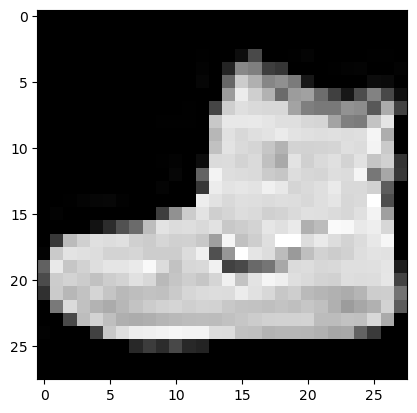

In [49]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);


Jeremy now defines an image plotting function for making nice images of our data.

- fc.delegates is a fastcore utility that lets you delegate a function to another function.  Replaces `**kwargs` in signature with params from the 'to' function, `plt.axes.imshow` in this case..

- In this case i think the only effect is to have all the options show up in the signature of the function or in help.  I tested with and without the delegates decorator and it worked the same except for the `help` output.


In [59]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [60]:
import inspect
inspect.signature(show_image)

<Signature (im, ax=None, figsize=None, title=None, noframe=True, **kwargs)>

In [61]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs)
    Show a PIL or PyTorch image on `ax`.



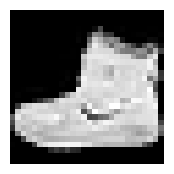

In [62]:
show_image(img, figsize=(2,2));

In a similar way Jeremy produces custom versions of subplots that uses show images and a funciton `get_grid` that produces an appropriately shaped grid of plots given the `n` the number of subplots required.  He uses this to create `show_images` to show multiple images appropriately labeled. The code is in `datasets.py`.  

He takes this time to demonstrate the nbdev documentation feature, where it generates documenation from comments in the code.  (There are other libraries for this as well)

Finally he creates a class `DataLoaders` with a class methong `from_dd` that uses `collate_dict` to create a dataloader from a hugginface dataset.


In [ ]:

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

# Part 3: Foundations

Now we go to YET another notebook, this one called `06_Foundations.ipynb`.   I am really starting to dislike the format of this second course. It is difficult to navigate since he jumps subjects in the middle of videos for one thing.   But also the way he uses unnecessary addition concepts (like `fastcore` and `nbdev`) is also distracting from the main points.  But other people love it , so perhaps it is just me.

This is as about 1:30 in the video.    Concepts discussed:

* Callbacks

   * In ipywidgets
   
   * In functions that do slow calculations (e.g. training functions)  )

* Lamndas 

   * Anonymouse functions as callbacks 

   * As a way to create functions that get returned by an outer function. (Note that pythonic way is to define the inner function normally in the outer function scope)

* partial (currying) - Can often be used instead of functions that return functions. (I.e. instead of using lambdas)

* using Classes: 
     * Callable classes can be used as callbacks
     * Can also be more flexible, with methods 'before_fit' and 'after_fit' for example. 

* *args and **kwargs

   * *args:  a tuple of all the positional arguments 
   * **kwargs: a dictionary of all the keyword arguments
   * The `*` and `**` work the other way as well, to unpack the tuple or dictionary into arguments. ('splat' operator). Very handy for passing in parameters.

* python data model (dunder methods).  Suggests looking at the python data model for more information.  

He has been using these all along, so why didnt he explain these before?